# Fraud Detection Model Training

This notebook loads the dataset, preprocesses it, trains a Random Forest model, analyzes feature importance, and saves the model and feature columns for deployment. Visualizations are included for data exploration and feature importance.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import os

## 1. Load Data

In [2]:
df = pd.read_csv('Dataset.csv')
print('Initial shape:', df.shape)
df.head()

Initial shape: (535178, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,11,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',52.35,0
1,172,'C1222389110','3','M','28007','M1823072687','28007','es_transportation',14.75,0
2,106,'C879949041','3','F','28007','M1823072687','28007','es_transportation',3.73,0
3,86,'C409740988','5','M','28007','M1823072687','28007','es_transportation',61.42,0
4,152,'C671449181','3','F','28007','M692898500','28007','es_health',9.05,0


## 2. Data Cleaning & Preprocessing

In [ ]:
# Clean columns
df.columns = df.columns.str.strip()
# Drop columns only if they exist to avoid KeyError
for col in ['zipcodeOri', 'zipMerchant', 'customer']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Fill missing values
df['gender'] = df['gender'].replace(['E', 'U'], np.nan)
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
gender_mode = df['gender'].mode()[0] if not df['gender'].mode().empty else 1
df['gender'] = df['gender'].fillna(gender_mode)

for col in ['step', 'age', 'amount']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    median = df[col].median()
    df[col] = df[col].fillna(median)

df['merchant'] = df['merchant'].fillna('unknown')
df['category'] = df['category'].fillna('unknown')

c:\Users\gudde\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Class Distribution

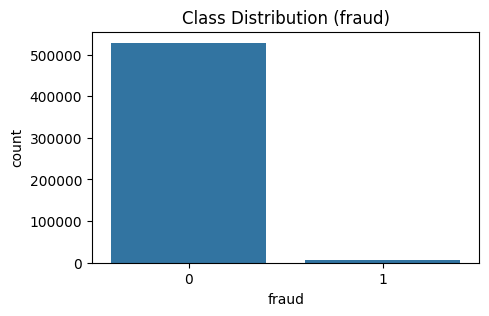

In [7]:
plt.figure(figsize=(5,3))
sns.countplot(x='fraud', data=df)
plt.title('Class Distribution (fraud)')
plt.show()

## 3. One-hot Encoding

In [8]:
df = pd.get_dummies(df, columns=['merchant', 'category'], drop_first=True)
df.head()

,step,age,gender,amount,fraud,merchant_'M117188757',merchant_'M1198415165',merchant_'M1294758098',merchant_'M1313686961',merchant_'M1352454843',...,category_'es_home',category_'es_hotelservices',category_'es_hyper',category_'es_leisure',category_'es_otherservices',category_'es_sportsandtoys',category_'es_tech',category_'es_transportation',category_'es_travel',category_'es_wellnessandbeauty'
0,11,NaN,1.0,52.35,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,172,NaN,1.0,14.75,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,106,NaN,1.0,3.73,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,86,NaN,1.0,61.42,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,152,NaN,1.0,9.05,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 4. Train/Test Split

In [9]:
X = df.drop('fraud', axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (428142, 67) Test shape: (107036, 67)


## 5. Train Random Forest Model

In [10]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105723
           1       0.86      0.77      0.81      1313

    accuracy                           1.00    107036
   macro avg       0.93      0.89      0.91    107036
weighted avg       1.00      1.00      1.00    107036



## 6. Feature Importance

In [11]:
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.head(10)

,feature,importance
3,amount,0.519953
0,step,0.106132
52,merchant_'M980657600',0.064010
37,merchant_'M480139044',0.059802
62,category_'es_sportsandtoys',0.049785
60,category_'es_leisure',0.024428
65,category_'es_travel',0.022697
43,merchant_'M732195782',0.013547
56,category_'es_health',0.013041
24,merchant_'M1873032707',0.011660


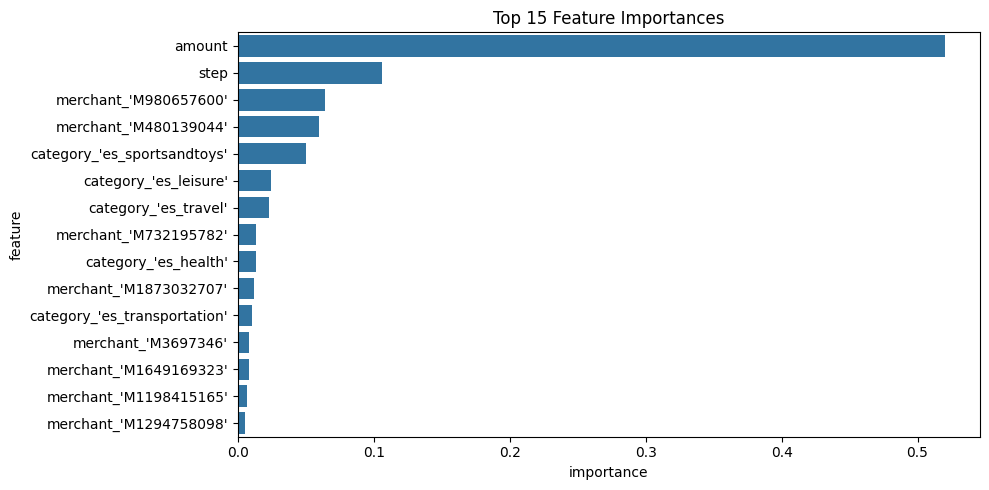

In [12]:
# Plot feature importances
plt.figure(figsize=(10,5))
sns.barplot(x='importance', y='feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

## 7. Select Important Features and Retrain

In [13]:
# Keep features with >1% importance, or all if all are important
threshold = 0.01
selected_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
if len(selected_features) == 0:
    selected_features = feature_names.tolist()
print('Selected features:', selected_features)

X_selected = X[selected_features]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_sel, y_train_sel)
print(classification_report(y_test_sel, model.predict(X_test_sel)))

Selected features: ['amount', 'step', "merchant_'M980657600'", "merchant_'M480139044'", "category_'es_sportsandtoys'", "category_'es_leisure'", "category_'es_travel'", "merchant_'M732195782'", "category_'es_health'", "merchant_'M1873032707'", "category_'es_transportation'"]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105723
           1       0.83      0.72      0.77      1313

    accuracy                           0.99    107036
   macro avg       0.91      0.86      0.88    107036
weighted avg       0.99      0.99      0.99    107036



## 8. Save Model and Feature Columns

In [14]:
os.makedirs('model', exist_ok=True)
with open('model/fraud_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('model/feature_columns.pkl', 'wb') as f:
    pickle.dump(selected_features, f)
print('Model and feature columns saved!')

Model and feature columns saved!


## 9. Test the model on a new test dataset

In [ ]:
test_df = pd.read_csv('TestDataset.csv')  # Change filename as needed

# --- Preprocess test data as before ---
test_df.columns = test_df.columns.str.strip()
for col in ['zipcodeOri', 'zipMerchant', 'customer']:
    if col in test_df.columns:
        test_df.drop(col, axis=1, inplace=True)
test_df['gender'] = test_df['gender'].replace(['E', 'U'], np.nan)
test_df['gender'] = test_df['gender'].map({'M': 1, 'F': 0})
gender_mode = test_df['gender'].mode()[0] if not test_df['gender'].mode().empty else 1
test_df['gender'] = test_df['gender'].fillna(gender_mode)
for col in ['step', 'age', 'amount']:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    median = test_df[col].median()
    test_df[col] = test_df[col].fillna(median)
test_df['merchant'] = test_df['merchant'].fillna('unknown')
test_df['category'] = test_df['category'].fillna('unknown')
test_df = pd.get_dummies(test_df, columns=['merchant', 'category'], drop_first=True)

# --- Align columns to model features ---
with open('model/feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)
for col in feature_columns:
    if col not in test_df.columns:
        test_df[col] = 0
test_X = test_df[feature_columns]

# --- Load model and predict ---
with open('model/fraud_model.pkl', 'rb') as f:
    model = pickle.load(f)
test_preds = model.predict(test_X)

# If ground truth is available in test set:
if 'fraud' in test_df.columns:
    print(classification_report(test_df['fraud'], test_preds))

# Otherwise, just output predictions:
print('Predictions:', test_preds[:10])  # Show first 10 predictions